In [ ]:
!git clone  https://github.com/mohammadataei93/Emojify-Comments-LSTM.git
!pip install emoji
!pip install patool

In [9]:
import os
os.chdir('/content/Emojify-Comments-LSTM')
os.getcwd()
import numpy as np
from emo_utils import *
import emoji
import matplotlib.pyplot as plt
import patoolib

%matplotlib inline

<a name='1'></a>
## 1 - Baseline Model


In [4]:
X_train, Y_train = read_csv('data/train_emoji.csv')
X_test, Y_test = read_csv('data/test_emoji.csv')

In [5]:
maxLen = len(max(X_train, key=len).split())

In [6]:
for idx in range(10):
    print(X_train[idx], label_to_emoji(Y_train[idx]))

never talk to me again 😞
I am proud of your achievements 😄
It is the worst day in my life 😞
Miss you so much ❤️
food is life 🍴
I love you mum ❤️
Stop saying bullshit 😞
congratulations on your acceptance 😄
The assignment is too long  😞
I want to go play ⚾


In [7]:
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

In [8]:
idx = 50
print(f"Sentence '{X_train[50]}' has label index {Y_train[idx]}, which is emoji {label_to_emoji(Y_train[idx])}", )
print(f"Label index {Y_train[idx]} in one-hot encoding format is {Y_oh_train[idx]}")

Sentence 'I missed you' has label index 0, which is emoji ❤️
Label index 0 in one-hot encoding format is [1. 0. 0. 0. 0.]


In [13]:
patoolib.extract_archive("/content/Emojify-Comments-LSTM/data/glove.6B.50d.txt.zip", outdir="/content/Emojify-Comments-LSTM/data")

patool: Extracting /content/Emojify-Comments-LSTM/data/glove.6B.50d.txt.zip ...
patool: running /usr/bin/7z x -o/content/Emojify-Comments-LSTM/data -- /content/Emojify-Comments-LSTM/data/glove.6B.50d.txt.zip
patool: ... /content/Emojify-Comments-LSTM/data/glove.6B.50d.txt.zip extracted to `/content/Emojify-Comments-LSTM/data'.


'/content/Emojify-Comments-LSTM/data'

In [14]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

In [15]:
word = "direct"
idx = 289300
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(idx) + "th word in the vocabulary is", index_to_word[idx])

the index of direct in the vocabulary is 124729
the 289300th word in the vocabulary is portway


In [16]:
def sentence_to_avg(sentence, word_to_vec_map):

    any_word = list(word_to_vec_map.keys())[0]
    words = sentence.lower().split()
    avg = np.zeros(word_to_vec_map[any_word].shape[0])
    count = 0
    for w in words:
        if w in word_to_vec_map:
            avg += word_to_vec_map[w]
            count +=1
    if count > 0:
        avg = avg / count
    return avg

In [17]:
avg = sentence_to_avg("Morrocan couscous is my favorite dish", word_to_vec_map)
print("avg = \n", avg)

avg = 
 [-0.008005    0.56370833 -0.50427333  0.258865    0.55131103  0.03104983
 -0.21013718  0.16893933 -0.09590267  0.141784   -0.15708967  0.18525867
  0.6495785   0.38371117  0.21102167  0.11301667  0.02613967  0.26037767
  0.05820667 -0.01578167 -0.12078833 -0.02471267  0.4128455   0.5152061
  0.38756167 -0.898661   -0.535145    0.33501167  0.68806933 -0.2156265
  1.797155    0.10476933 -0.36775333  0.750785    0.10282583  0.348925
 -0.27262833  0.66768    -0.10706167 -0.283635    0.59580117  0.28747333
 -0.3366635   0.23393817  0.34349183  0.178405    0.1166155  -0.076433
  0.1445417   0.09808667]


In [18]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    any_word = list(word_to_vec_map.keys())[0]
    cost = 0
    m = Y.shape[0]                             
    n_y = len(np.unique(Y))                    
    n_h = word_to_vec_map[any_word].shape[0] 
    
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))

    Y_oh = convert_to_one_hot(Y, C = n_y) 

    for t in range(num_iterations): 
        for i in range(m):          
            avg = sentence_to_avg(X[i], word_to_vec_map)
            z = np.dot(W, avg) + b
            a = softmax(z)
            cost = -np.sum(Y_oh[i]*np.log(a))

            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map) #predict is defined in emo_utils.py

    return pred, W, b

In [ ]:
np.random.seed(1)
pred, W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

In [20]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.9772727272727273
Test set:
Accuracy: 0.8571428571428571


In [21]:
X_my_sentences = np.array(["i adore you", "i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 0.8333333333333334

i adore you ❤️
i love you ❤️
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
not feeling happy 😄


(56,)
           ❤️    ⚾    😄    😞   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            2    0   16    0    0   18
3            1    1    2   12    0   16
4            0    0    1    0    6    7
All          9    9   19   13    6   56


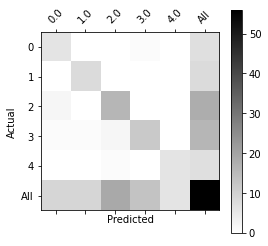

In [22]:
# START SKIP FOR GRADING
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)
# END SKIP FOR GRADING

<a name='2'></a>
## 2 - Emojifier: Using LSTMs in Keras 

In [23]:
import numpy as np
import tensorflow
np.random.seed(0)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
np.random.seed(1)

In [24]:
def sentences_to_indices(X, word_to_index, max_len):
    m = X.shape[0]                                   
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):    
        sentence_words = X[i].lower().split()
        j = 0
        for w in sentence_words:
            if w in word_to_index:
                X_indices[i, j] = word_to_index[w]
                j +=1
    return X_indices

In [25]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1, word_to_index, max_len=5)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices =
 [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


In [26]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    vocab_size = len(word_to_index) + 1             
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0]   

    emb_matrix = np.zeros((vocab_size,emb_dim))

    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    embedding_layer = Embedding(vocab_size, emb_dim, trainable=False)
    embedding_layer.build((None,)) 
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [27]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][1] =", embedding_layer.get_weights()[0][1][1])
print("Input_dim", embedding_layer.input_dim)
print("Output_dim",embedding_layer.output_dim)

weights[0][1][1] = 0.39031
Input_dim 400001
Output_dim 50


In [28]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    sentence_indices = Input(shape=input_shape,dtype='int32')
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)

    embeddings = embedding_layer(sentence_indices)   
    X = LSTM(units = 128, return_sequences= True)(embeddings)
    X = Dropout(rate = 0.5)(X)
    X = LSTM(units=128,return_sequences=False)(X)
    X = Dropout(rate = 0.5)(X) 
    X = Dense(units = 5)(X)
    X = Activation('softmax')(X)

    model = Model(inputs= sentence_indices, outputs= X)
    
    return model

In [29]:
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm (LSTM)                  (None, 10, 128)           91648     
_________________________________________________________________
dropout (Dropout)            (None, 10, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 645   

In [31]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

In [32]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
5/5 [==============================] - 8s 11ms/step - loss: 1.5871 - accuracy: 0.2197
Epoch 2/50
5/5 [==============================] - 0s 10ms/step - loss: 1.5080 - accuracy: 0.3333
Epoch 3/50
5/5 [==============================] - 0s 10ms/step - loss: 1.4303 - accuracy: 0.4167
Epoch 4/50
5/5 [==============================] - 0s 10ms/step - loss: 1.3485 - accuracy: 0.4848
Epoch 5/50
5/5 [==============================] - 0s 10ms/step - loss: 1.2315 - accuracy: 0.5303
Epoch 6/50
5/5 [==============================] - 0s 10ms/step - loss: 1.0891 - accuracy: 0.5909
Epoch 7/50
5/5 [==============================] - 0s 10ms/step - loss: 1.0108 - accuracy: 0.6212
Epoch 8/50
5/5 [==============================] - 0s 11ms/step - loss: 0.8061 - accuracy: 0.7273
Epoch 9/50
5/5 [==============================] - 0s 10ms/step - loss: 0.7254 - accuracy: 0.7500
Epoch 10/50
5/5 [==============================] - 0s 12ms/step - loss: 0.6748 - accuracy: 0.7727
Epoch 11/50
5/5 [============

In [33]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

2/2 [==============================] - 1s 14ms/step - loss: 0.5015 - accuracy: 0.8571

Test accuracy =  0.8571428656578064


In [34]:
# This code allows you to see the mislabelled examples
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

Expected emoji:😄 prediction: she got me a nice present	❤️
Expected emoji:😄 prediction: he is a good friend	❤️
Expected emoji:😞 prediction: This girl is messing with me	❤️
Expected emoji:😄 prediction: you brighten my day	❤️
Expected emoji:😞 prediction: she is a bully	❤️
Expected emoji:😞 prediction: My life is so boring	❤️
Expected emoji:😄 prediction: will you be my valentine	❤️
Expected emoji:😞 prediction: go away	⚾


Now you can try it on your own example! Write your own sentence below:

In [35]:
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.  
x_test = np.array(['I Like Football'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

I Like Football ⚾
